# Neural ODEs

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
from torchdiffeq import odeint_adjoint as odeint
import IPython
%matplotlib inline

## Pendulum ODE

$$
\begin{align}
\frac{d}{dt} \begin{bmatrix} \theta \\ \omega \end{bmatrix} &= \begin{bmatrix} \omega \\ - \sin\theta \end{bmatrix} \\
\theta(0) &= \frac{3\pi}{4} \\
\omega(0) &= 0 \\
t &\in [0,10]
\end{align}
$$

## Tasks

1. Generate training data by simulating a trajectory of the system
2. Train a Neural ODE to fit the simulated trajectory
3. Plot the vector field of your Neural ODE
4. How well does your Neural ODE genearlize to other initial conditions? Can you improve this?

In [32]:
data_size = 100
batch_time = 10
batch_size = 20

In [33]:
t = torch.linspace(0., 10., data_size)
u_0 = torch.tensor([3*torch.pi/4, 0.])

class TrueFunc(torch.nn.Module):
    def forward(self, t, u):
        return torch.tensor([u[1], -torch.sin(u[0])])

with torch.no_grad():
    u = odeint(TrueFunc(), u_0, t, method='dopri5')

In [34]:
class ODEFunc(torch.nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 2),
        )
        for m in self.net.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0, std=0.1)
                torch.nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [35]:
func = ODEFunc()
opt = torch.optim.RMSprop(func.parameters(), lr=1e-3)
loss_history = []

In [36]:
def plot_trajectories(plot_pred=True):
    with torch.no_grad():
        plt.plot(u[:,0], u[:,1], label='true')
        if plot_pred:
            pred_y = odeint(func, u_0, t, method='dopri5')
            plt.plot(pred_y[:,0], pred_y[:,1], 'r--', label='NeuralODE')
        plt.gca().set_aspect('equal')
        plt.legend()

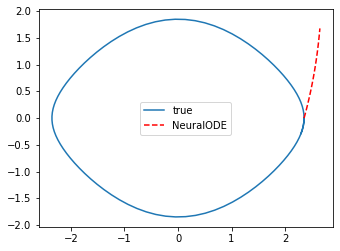

In [38]:
plot_trajectories()

In [41]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_u0 = u[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_u = torch.stack([u[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_u0, batch_t, batch_u

In [42]:
get_batch()

(tensor([[ 2.3562,  0.0000],
         [-1.8463,  0.9328],
         [-2.2011,  0.4853],
         [-2.3340,  0.1783],
         [-2.0155,  0.7442],
         [ 2.0473,  0.7049],
         [ 0.5087, -1.7779],
         [-1.3890,  1.3326],
         [-1.7426, -1.0355],
         [ 0.5009,  1.7800],
         [ 1.6914, -1.0833],
         [ 1.4522, -1.2848],
         [-0.6017,  1.7501],
         [ 2.1140,  0.6168],
         [-1.2431, -1.4345],
         [ 2.0504, -0.7009],
         [ 1.0187, -1.5694],
         [ 0.8560, -1.6508],
         [-2.0832, -0.6585],
         [ 0.6856, -1.7211]]),
 tensor([0.0000, 0.1010, 0.2020, 0.3030, 0.4040, 0.5051, 0.6061, 0.7071, 0.8081,
         0.9091]),
 tensor([[[ 2.3562,  0.0000],
          [-1.8463,  0.9328],
          [-2.2011,  0.4853],
          [-2.3340,  0.1783],
          [-2.0155,  0.7442],
          [ 2.0473,  0.7049],
          [ 0.5087, -1.7779],
          [-1.3890,  1.3326],
          [-1.7426, -1.0355],
          [ 0.5009,  1.7800],
          [ 1.6914

In [43]:
sample_t = t[:10]
for epoch in range(100):
    opt.zero_grad()

    # compute the loss function by sampling many short trajectory segments
    # ... fill this in ...
    batch_u0, batch_t, batch_u = get_batch()
    pred_u = odeint(func, batch_u0, batch_t)
    loss = torch.mean(torch.abs(pred_u - batch_u))
    # store and print current loss value
    loss_history.append(loss.item())
    IPython.display.clear_output(wait=True)
    print(f'{epoch}: {loss.item()}')

    # differentiate and take a gradient step
    loss.backward()
    opt.step()

99: 0.05943802744150162


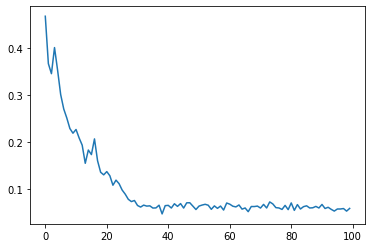

In [45]:
plt.plot(loss_history)


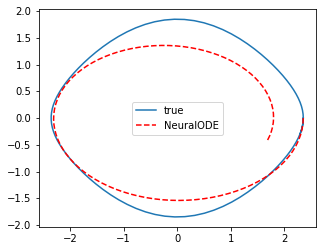

In [46]:
plot_trajectories()

## Hints

1. We are using the package https://github.com/rtqichen/torchdiffeq
2. See the example: https://github.com/rtqichen/torchdiffeq/blob/master/examples/ode_demo.py